In [1]:
using Sobol, StatsBase, Optim, Plots
using StatsFuns: norminvcdf

In [155]:
include("nsrl.jl")

In [156]:
# Generate Sobol uniforms in (0,1)^d
function sobol_uniform(n::Int, d::Int)
    seq = SobolSeq(d)
    U = Array{Float64}(undef, n, d)
    for i in 1:n
        U[i, :] = next!(seq)    # each is in [0,1)
    end
    return U
end

# Map to standard normals elementwise via probit (inverse CDF)
function sobol_normals(n::Int, d::Int; eps::Float64 = 1e-12)
    U = sobol_uniform(n, d)
    clamp!(U, eps, 1 - eps)     # avoid 0 or 1 -> ±Inf after inverse-CDF
    return norminvcdf.(U)       # elementwise inverse CDF
    # alternatively:
    # return quantile.(Normal(), U)
    # return sqrt(2) .* erfinv.(2 .* U .- 1)
end

sobol_normals (generic function with 1 method)

In [157]:

# Use 4 dims: 2 for x-plane, 2 for y-plane
N = 500_000
Z = sobol_normals(N, 4)
Zx = Z[:, 1:2]
Zy = Z[:, 3:4]

epsilon_a = 7.7e-6
epsilon_b = 7.7e-6

beta_a = 7
beta_b = 8
alpha_a = -0.3
alpha_b = -0.8


Mx = [sqrt(beta_a) 0; -alpha_a/sqrt(beta_a) 1/sqrt(beta_a)]
My = [sqrt(beta_b) 0; -alpha_b/sqrt(beta_b) 1/sqrt(beta_b)]


coords_x = sqrt(epsilon_a) .* (Zx * Mx')
coords_y = sqrt(epsilon_b) .* (Zy * My')
coords_z = zeros(N, 2)

coords = hcat(coords_x, coords_y, coords_z)
b0 = Bunch(coords, species = Ta, R_ref = R)

bunch = deepcopy(b0)

Bunch{Float64, Float64, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}}(Species(#181Ta+73, charge=73.0e, mass=1.6851468800901855e11 eV/c², spin=90.5ħ), 7.203299138182853, 0.0, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}(UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01  …  0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01], [0.0 0.0 … 0.0 0.0; 0.004951875726040082 -0.0004951875726040081 … 0.0 0.0; … ; -0.013087319988996 6.399101071971712e-5 … 0.0 0.0; -0.011870735146168 -0.0006174661945436433 … 0.0 0.0], nothing))

In [ ]:
function hist(bunch; nx=1000, ny=1000, xlims=(-0.2, 0.2), ylims=(-0.2, 0.2), plot=true)

    x = bunch.coords.v[:, 1]
    y = bunch.coords.v[:, 3]

    # Compute histogram data using StatsBase
    if xlims == nothing || ylims == nothing
        # Automatic limits - compute from data
        hist_data = fit(Histogram, (x, y), nbins=(nx, ny))
        xlims = (hist_data.edges[1][1], hist_data.edges[1][end])
        ylims = (hist_data.edges[2][1], hist_data.edges[2][end])
    else
        # Use provided limits
        x_range = range(xlims[1], xlims[2], length=nx+1)
        y_range = range(ylims[1], ylims[2], length=ny+1)
        hist_data = fit(Histogram, (x, y), (x_range, y_range))
    end
    
    # If plot=false, just return the histogram data
    if !plot
        return hist_data
    end
    
    # Otherwise, create the plot
    # Main 2D histogram (heatmap) without colorbar
    p_main = histogram2d(x, y;
        nbins=(nx, ny),
        xlims=xlims,
        ylims=ylims,
        xlabel="x (m)",
        ylabel="y (m)",
        title="Beam profile at Target",
        colorbar=false,
        aspect_ratio=1,
    )

    # Create marginal histograms by reusing histogram() function from Plots
    x_range = range(xlims[1], xlims[2], length=nx+1)
    y_range = range(ylims[1], ylims[2], length=ny+1)

    # Extract the data from histogram plots (but don't display them)
    h_x = histogram(x, bins=x_range, normalize=false)
    h_y = histogram(y, bins=y_range, normalize=false)

    # Extract coordinates from the plots - use the recipe data
    # For histograms, Plots stores the step coordinates
    x_bins   = h_x.series_list[1][:x]
    x_counts = h_x.series_list[1][:y]
    y_bins   = h_y.series_list[1][:x]
    y_counts = h_y.series_list[1][:y]

    # Convert step histogram coordinates to bin centers and counts
    xc   = x_bins[2:2:end-1]    # Bin centers
    xcnt = x_counts[2:2:end]    # Counts
    yc   = y_bins[2:2:end-1]    # Bin centers
    ycnt = y_counts[2:2:end]    # Counts

    # Top (x marginal)
    p_top = plot(xc, xcnt;
        legend=false,
        xlims=xlims,
        xlabel="",
        ylabel="Count",
        title="X marginal",
        grid=false,
    )
    # Hide x-axis on top plot
    xaxis!(p_top, false)

    # Right (y marginal)
    p_right = plot(ycnt, yc;
        legend=false,
        ylims=ylims,
        xlabel="Count",
        ylabel="",
        title="Y marginal",
        grid=false,
    )

    # Empty spacer for top-right
    p_blank = plot(framestyle=:none, axis=false)

    # Compose layout: top row (p_top, blank), bottom row (p_main, p_right)
    # With aspect_ratio=1 on p_main, we need to adjust heights/widths to match
    # the data aspect ratio for proper alignment
    x_range = xlims[2] - xlims[1]
    y_range = ylims[2] - ylims[1]
    data_aspect = x_range / y_range
    
    # Set the main plot area to be square in the layout since aspect_ratio=1
    # The marginal plots should be proportional to maintain alignment
    marginal_fraction = 0.2  # fraction of space for marginals
    main_fraction = 1 - marginal_fraction
    
    l = grid(2, 2, heights=[marginal_fraction, main_fraction], widths=[main_fraction, marginal_fraction])
    return plot(p_top, p_blank, p_main, p_right; layout=l, size=(850, 850))
end

hist (generic function with 1 method)

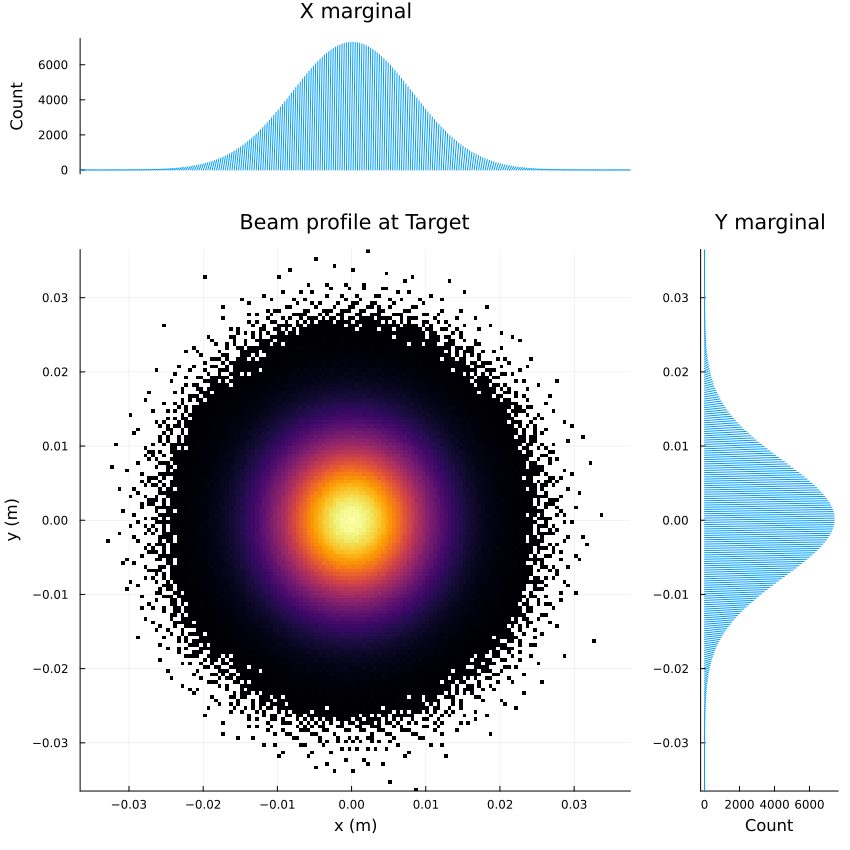

In [159]:
hist(bunch, nx=250, ny=250, xlims=nothing, ylims=nothing)

In [160]:
track!(bunch, nsrl)

Bunch{Float64, Float64, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}}(Species(#181Ta+73, charge=73.0e, mass=1.6851468800901855e11 eV/c², spin=90.5ħ), 7.203299138182853, 4.90967743121352e-7, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}(UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01  …  0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01], [1.3801293162048244e-15 -2.68658273817705e-17 … -7.771561172376097e-16 0.0; -0.01562603252607835 0.0003187205838748584 … 0.00036959256709703396 0.0; … ; -0.03079498822056564 0.0010830794901157447 … 4.5794718021083714e-5 0.0; -0.044590995626874574 0.0012588647515419694 … 0.0010729797092583217 0.0], nothing))

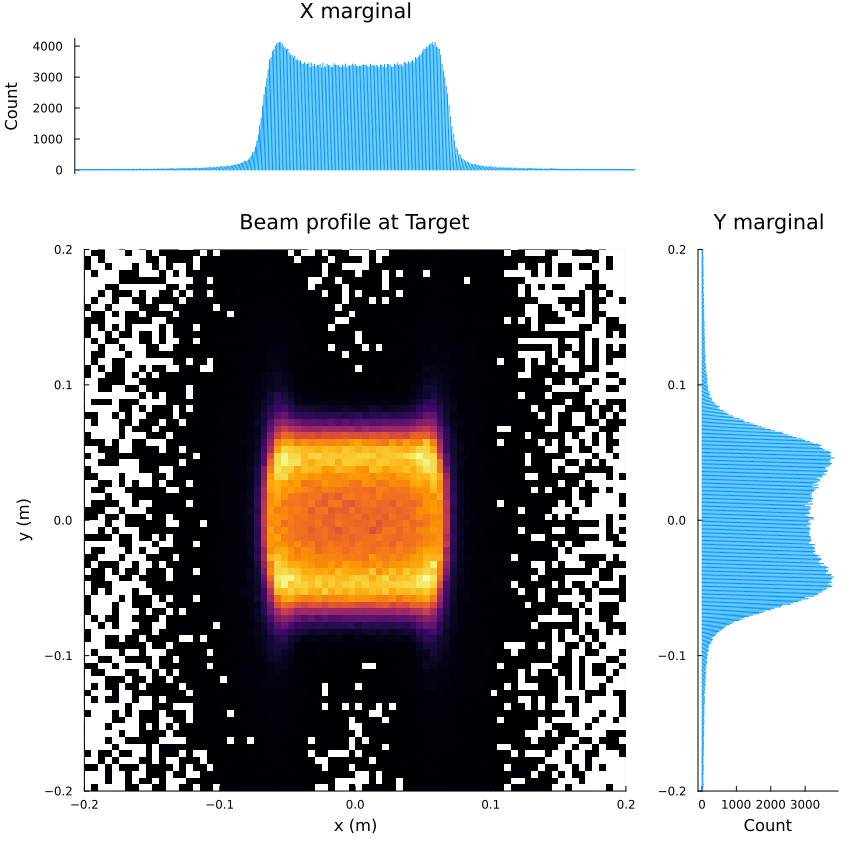

In [161]:
p0 = hist(bunch, nx=400, ny=400)

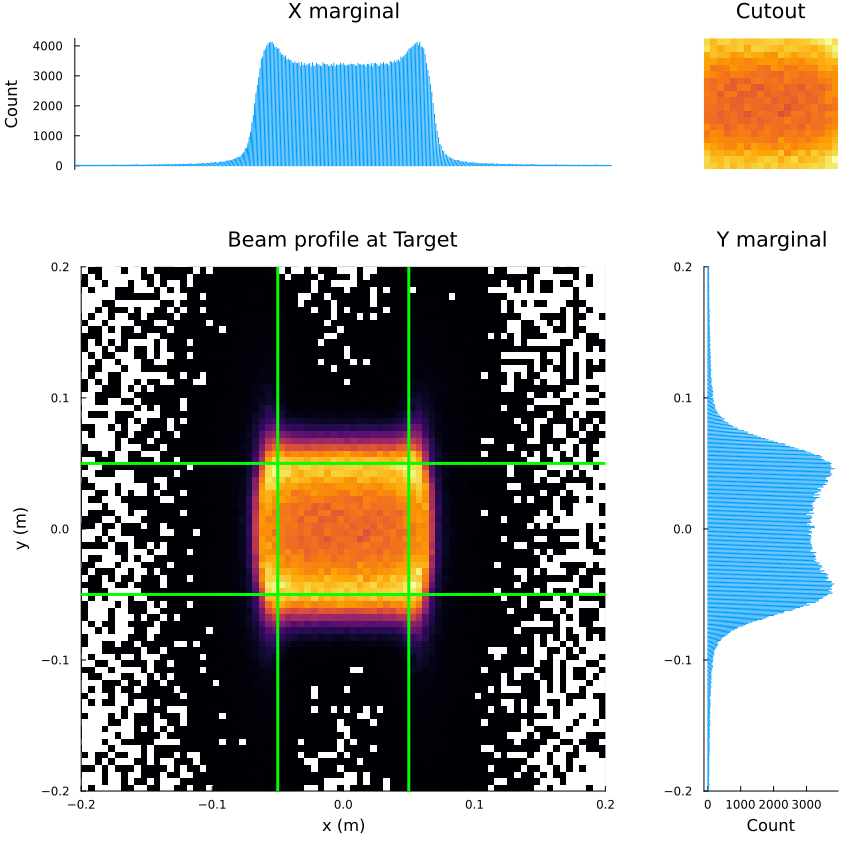

In [162]:
v = 0.05
h = 0.05

xb      = p0[3].series_list[1][:x];
yb      = p0[3].series_list[1][:y];
density = p0[3].series_list[1][:z].surf;

h_step = Float64(xb.step)
v_step = Float64(yb.step)

h_center = Int(round((0. - xb[1]) / h_step) + 1)
v_center = Int(round((0. - yb[1]) / v_step) + 1)

h_rng = (h_center - Int(round(h / h_step))+1):(h_center + Int(round(h / h_step)))
v_rng = (v_center - Int(round(v / v_step))+1):(v_center + Int(round(v / v_step)))

tmp = deepcopy(p0)
hline!(tmp[3], [-v, v], lw=3, lc=:lime, label=nothing)
vline!(tmp[3], [-h, h], lw=3, lc=:lime, label=nothing)
cutout_color_range = (minimum(filter(!isnan, density)), maximum(filter(!isnan, density)))
heatmap!(tmp[2], xb[h_rng], yb[v_rng], density[v_rng, h_rng], xlabel="x (m)", ylabel="y (m)", title="Cutout", colorbar=false, clims=cutout_color_range)

In [22]:
_tmp = density[v_rng, h_rng]
println("Portion of total: ", sum(_tmp) / bunch.coords.v.size[1] * 100, " %")
println("Mean: ", round(mean(_tmp), digits=3))
println("STD: ", round(std(_tmp), digits=3))
println("Max: ", maximum(_tmp), "  Min: ", minimum(_tmp))

Portion of total: 47.666 %
Mean: 59.582
STD: 9.26
Max: 89.0  Min: 36.0


In [ ]:
function box(hist_data::Histogram; h=0.05, v=0.05)

    # Extract histogram data
    n_total = sum(hist_data.weights)

    h_step = Float64(hist_data.edges[1].step)
    v_step = Float64(hist_data.edges[2].step)

    h_center = Int(round((0. - hist_data.edges[1][1]) / h_step) + 1)
    v_center = Int(round((0. - hist_data.edges[2][1]) / v_step) + 1)

    h_rng = (h_center - Int(round(h / h_step))):(h_center + Int(round(h / h_step))-1)
    v_rng = (v_center - Int(round(v / v_step))):(v_center + Int(round(v / v_step))-1)

    return (hist_data.weights'[v_rng, h_rng], n_total)
end

function box_merit(box_result)
    box_data, n_total = box_result
    return (
        sum(box_data) / n_total,
        std(box_data) / mean(box_data)
    )
end

box_merit (generic function with 1 method)

In [ ]:
@btime box_merit( box(hist_data) ) setup=(b0=$b0, nsrl=$nsrl, hist_data=(b=deepcopy(b0); track!(b, nsrl); hist(b, nx=400, ny=400, plot=false)))

  111.915 ms (282 allocations: 3.67 MiB)


(0.47666, 0.15541018461068182)

In [ ]:
# Demonstration: Optimized usage with pre-computed histogram
# Track once and reuse the histogram data
bunch_tracked = deepcopy(b0)
track!(bunch_tracked, nsrl)

# Get histogram data without plotting (much faster!)
hist_data = hist(bunch_tracked, nx=400, ny=400, plot=false)

# Now use the histogram for multiple box evaluations
println("Using pre-computed histogram:")
@btime box_merit(box($hist_data, h=0.05, v=0.05)) 
println("\nCompare to tracking every time:")
@btime box_merit(box(hist_data, h=0.05, v=0.05)) setup=(b0=$b0, nsrl=$nsrl, hist_data=(b=deepcopy(b0); track!(b, nsrl); hist(b, nx=400, ny=400, plot=false)))


In [ ]:
merit_size = Array{Float64}(undef, 21, 21, 5, 2)

for (i, q3_b1) in enumerate(2:0.1:4)
    Q3.Bn1 = q3_b1
    for (j, q4_b1) in enumerate(-2:-0.1:-4)
        Q4.Bn1 = q4_b1
        
        # Track once and compute histogram for this magnet configuration
        try
            bunch_tmp = deepcopy(b0)
            track!(bunch_tmp, nsrl)
            hist_data = hist(bunch_tmp, nx=400, ny=400, plot=false)
            
            # Reuse histogram for different box sizes
            for (k, _size) in enumerate(0.05:0.01:0.09)
                merit_size[i, j, k, :] .= box_merit(box(hist_data, h=_size, v=_size))
            end
        catch
            println("Q3.Bn1 = ", q3_b1)
            println("Q4.Bn1 = ", q4_b1)
            b_tmp = deepcopy(b0)
            track!(b_tmp, nsrl)
            hist(b_tmp, nx=400, ny=400, xlims=nothing, ylims=nothing)
        end
    end
end

Q3.Bn1 = 3.6
Q4.Bn1 = -2.8
Q3.Bn1 = 3.6
Q4.Bn1 = -2.8


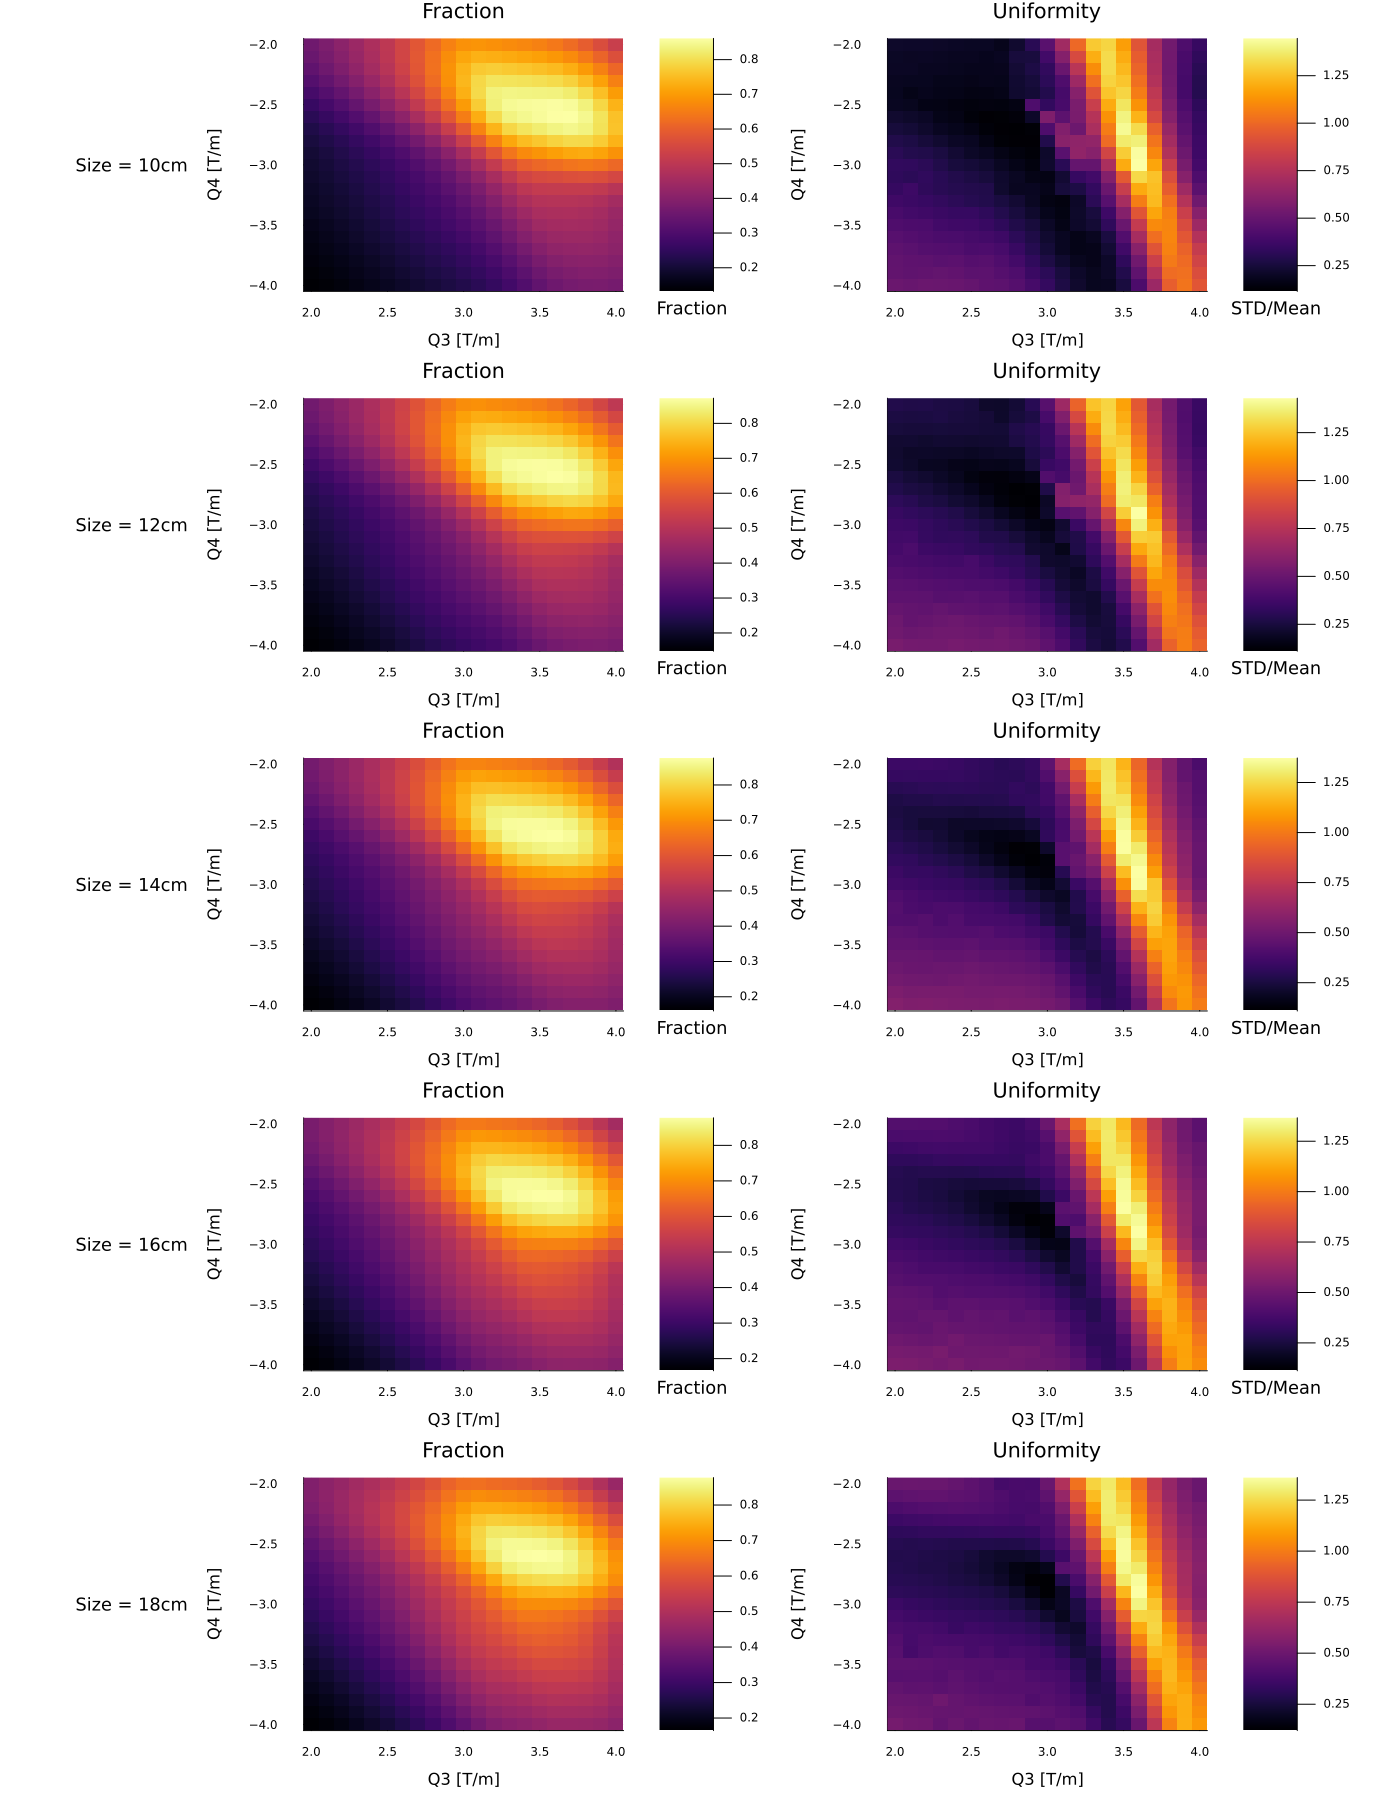

In [86]:
# Create plots for all 5 slices from the 3rd dimension
all_plots = []

for k in 1:5
    p_blank = plot(framestyle=:none, axis=false)
    annotate!(p_blank, 0.5, 0.5, text("Size = $(8+2*k)cm", :center, 12))

    p_left = heatmap(2:0.1:4, -4:0.1:-2, merit[:, end:-1:1, k, 1]', 
                     xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                     title="Fraction")
    annotate!(p_left, 4.5, -1.2, text("Fraction", :center, 12))
    
    p_right = heatmap(2:0.1:4, -4:0.1:-2, merit[:, end:-1:1, k, 2]', 
                      xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                      title="Uniformity")
    annotate!(p_right, 4.5, -1.2, text("STD/Mean", :center, 12))
    
    push!(all_plots, p_blank)
    push!(all_plots, p_left)
    push!(all_plots, p_right)
end

# Create layout with all plots: 5 rows, 3 columns with custom widths
l = grid(5, 3, heights=repeat([1/5], 5), widths=[0.15, 0.425, 0.425])
plot(all_plots..., layout=l, size=(1400, 1800))

In [ ]:
merit = Array{Float64}(undef, 21, 21, 5, 2)

for (i, q3_b1) in enumerate(2:0.1:4)
    Q3.Bn1 = q3_b1
    for (j, q4_b1) in enumerate(-2:-0.1:-4)
        Q4.Bn1 = q4_b1
        for (k, o_b3) in enumerate(1250:250:2250)
            O1.Bn3 = -o_b3
            O2.Bn3 =  o_b3

            try 
                bunch_tmp = deepcopy(b0)
                track!(bunch_tmp, nsrl)
                hist_data = hist(bunch_tmp, nx=400, ny=400, plot=false)
                merit[i, j, k, :] .= box_merit(box(hist_data, h=0.05, v=0.05))
            catch
                println("Q3.Bn1 = ", q3_b1)
                println("Q4.Bn1 = ", q4_b1)
                println("O.Bn3  = ", o_b3)
                b_tmp = deepcopy(b0)
                track!(b_tmp, nsrl)
                hist(b_tmp, nx=400, ny=400, xlims=nothing, ylims=nothing)
            end
        end
    end
end

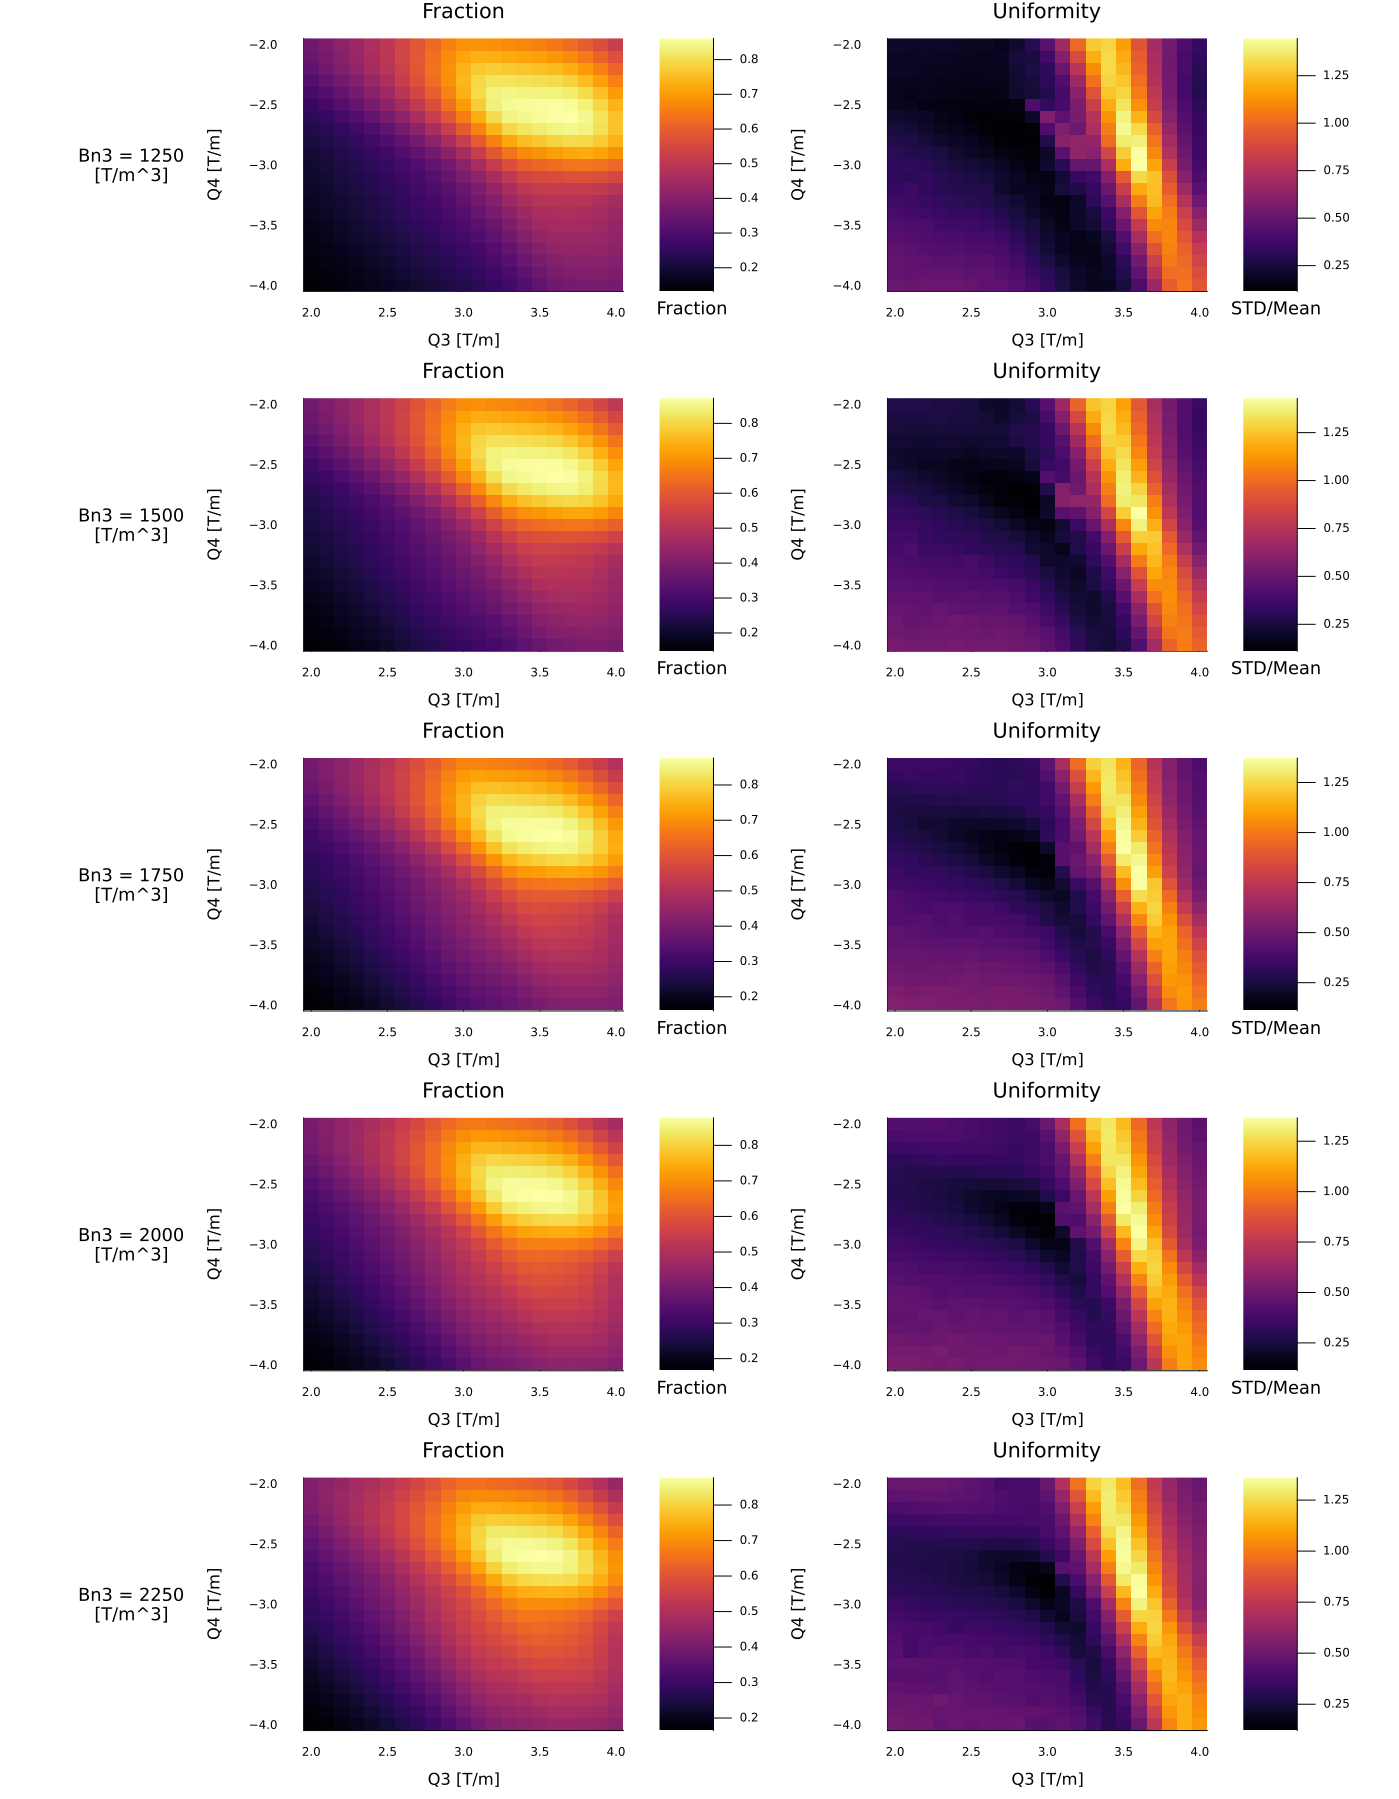

In [81]:
# Create plots for all 5 slices from the 3rd dimension
all_plots = []

for k in 1:5
    p_blank = plot(framestyle=:none, axis=false)
    annotate!(p_blank, 0.5, 0.5, text("Bn3 = $(1250+250*(k-1))\n[T/m^3]", :center, 12))

    p_left = heatmap(2:0.1:4, -4:0.1:-2, merit[:, end:-1:1, k, 1]', 
                     xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                     title="Fraction")
    annotate!(p_left, 4.5, -1.2, text("Fraction", :center, 12))
    
    p_right = heatmap(2:0.1:4, -4:0.1:-2, merit[:, end:-1:1, k, 2]', 
                      xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                      title="Uniformity")
    annotate!(p_right, 4.5, -1.2, text("STD/Mean", :center, 12))
    
    push!(all_plots, p_blank)
    push!(all_plots, p_left)
    push!(all_plots, p_right)
end

# Create layout with all plots: 5 rows, 3 columns with custom widths
l = grid(5, 3, heights=repeat([1/5], 5), widths=[0.15, 0.425, 0.425])
plot(all_plots..., layout=l, size=(1400, 1800))

In [ ]:
function func(x)
    Q3.Bn1 =  x[1]
    Q4.Bn1 =  x[2]
    O1.Bn3 = -x[3]
    O2.Bn3 =  x[3]
    bunch_tmp = deepcopy(b0)
    track!(bunch_tmp, nsrl)
    hist_data = hist(bunch_tmp, nx=400, ny=400, plot=false)
    frac, uniform = box_merit(box(hist_data, h = 0.07, v = 0.07))
    return uniform + exp(25*(0.7-frac)) 
end

x0    = [2.9, -2.9, 1.75e3]

res = optimize(func, x0, NelderMead())
bestx = Optim.minimizer(res)
bestf = Optim.minimum(res)
println("Best (Q3.Bn1, Q4.Bn1, O.Bn3) = ", bestx, "  cost = ", bestf)

Best (Q3.Bn1, Q4.Bn1, O.Bn3) = [2.967012114407703, -2.95254862450049, 1490.8026736329402]  cost = 0.1955841650705268


(0.847106, 0.13480316743342693)


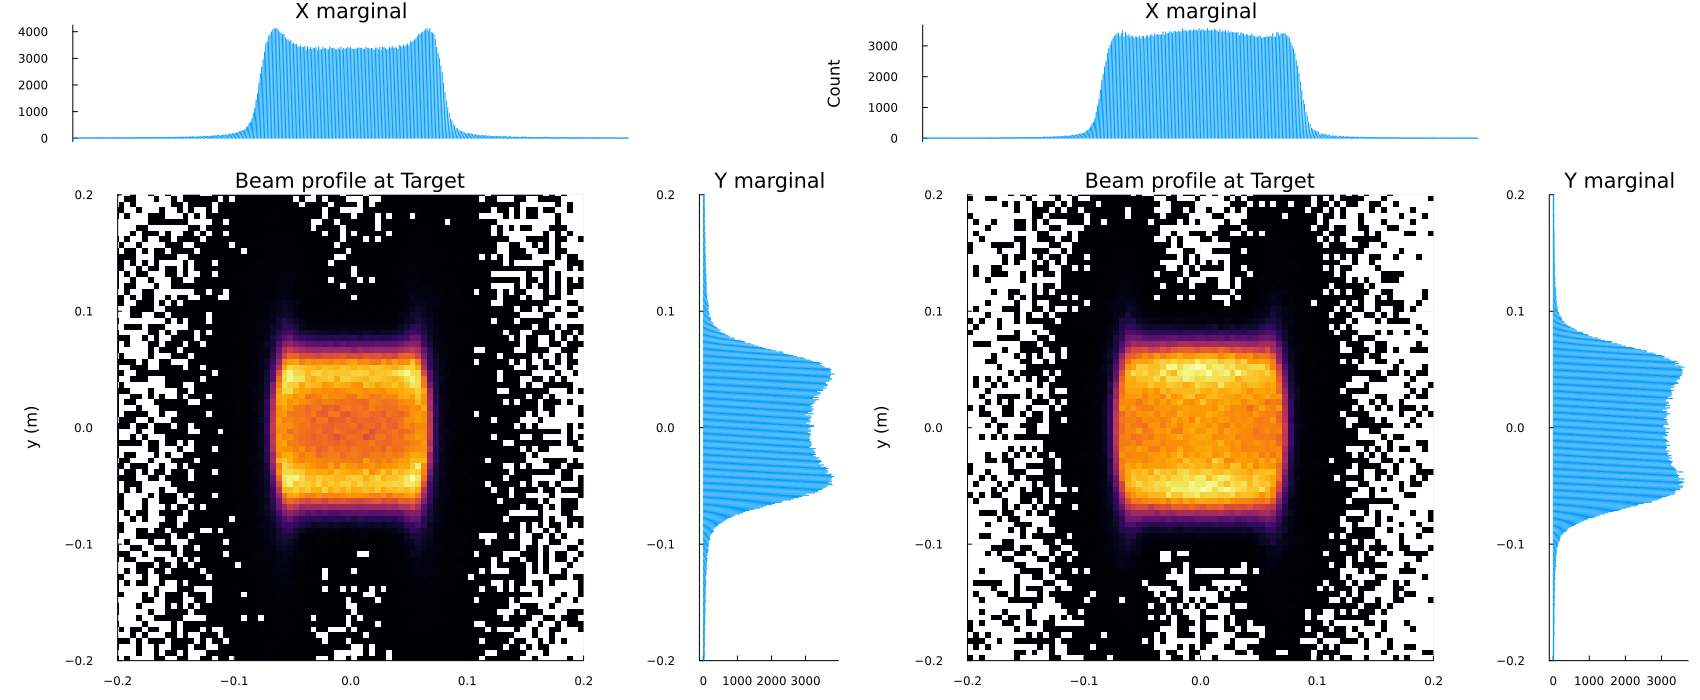

In [ ]:
println(box_merit(box(h = 0.07, v = 0.07)))

Q3.Bn1 = 2.967012114407703 #bestx[1]
Q4.Bn1 = -2.95254862450049  #bestx[2]
O1.Bn3 = -1490.8026736329402 #-bestx[3]
O2.Bn3 = 1490.8026736329402 #bestx[3]

println(box_merit(box(h = 0.07, v = 0.07)))
b_tmp = deepcopy(b0)
track!(b_tmp, nsrl)
p_tmp = hist(b_tmp, nx=400, ny=400);

plot(p0, p_tmp, size=(1700, 700))